<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab12_nlp-introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12 - Natural Language Processing - Introduction

### Author: Szymon Nowakowski


# Introduction
---------------
In this class, we take our first steps into Natural Language Processing (NLP). We'll begin by averaging word embeddings to form sentence-level representations—a simple but effective baseline. **Attention** generalizes this idea by learning which words matter more in context, assigning dynamic weights instead of treating each word equally. In this sense, **attention can be thought of as a learned, weighted average**.

This is our gateway into more advanced techniques. In the next class, we’ll study **self-attention**, the backbone of modern architectures like the Transformer. And if time permits, we may even explore the **full Transformer** model in our final class.

I would like to express my gratitude to my colleague Przemysław Olbratowski for this elegant way of introducing attention, which I find both intuitive and pedagogically effective.


# Google Crowdsource Sentiment Dataset  
--------------

It features **54k sentences** with **human-annotated emotion labels** from real-world user-generated content such as feedback, reviews, and comments.

Each sentence can be labeled with **one or more of 27 fine-grained emotion categories**, such as:
- *joy*, *amusement*, *approval*, *sadness*, *anger*, *fear*, *realization*, *pride*, etc.,  
plus an optional **neutral** label.

Because the dataset is **multi-label**, a single sentence may express a combination of emotions (e.g., *pride* and *fear*).

The dataset was released by Google as part of its **Crowdsource project** and is related to the **GoEmotions** initiative. It's particularly valuable for building models that understand nuanced emotional language in realistic user comments.




## Mapping emotions to sentiment

To use the dataset for **sentiment classification**, a rule-based mapping is applied to reduce multi-label emotion annotations into a single sentiment label:

- If **any emotion** in the label set is **positive** → classify as **Positive**
- Else if **any emotion** in the label set is **negative** → classify as **Negative**
- Else → classify as **Neutral**

This decision rule captures the dominant emotional tone of each sentence, simplifying the dataset for use in binary or ternary sentiment classification tasks.

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [3]:
from datasets import load_dataset
import pandas as pd

# Load the GoEmotions dataset (by Google)
dataset = load_dataset("go_emotions")

# Convert to binary sentiment (positive/neutral/negative)
def map_to_sentiment(example):
    positive = {
        1,   # admiration
        2,   # amusement
        3,   # approval
        7,   # caring
        10,  # desire
        12,  # excitement
        14,  # gratitude
        19,  # love
        20,  # optimism
        22,  # pride
        23,  # relief
        26   # joy
    }

    negative = {
        4,   # anger
        5,   # annoyance
        6,   # disapproval
        8,   # confusion
        9,   # disappointment
        11,  # embarrassment
        13,  # fear
        15,  # grief
        16,  # nervousness
        17,  # remorse
        18  # sadness
    }

    neutral = {
        0,   # neutral
        21,  # curiosity (ambiguous, context-specific)
        24,  # realization (realization label is often used for sentences that show understanding, acknowledgment, or reflection, without emotional intensity, like in “Oh, now I get what she meant” )
        25,  # surprise (can be negative or positive, but often context-specific)
        27   # none (used when no emotion is detected)
    }
    labels = set(example["labels"])
    if labels & positive:
        return "positive"
    elif labels & negative:
        return "negative"
    else:
        return "neutral"

# Apply sentiment mapping to each split
train_dataset = dataset["train"].map(lambda x: {"sentiment": map_to_sentiment(x)})
val_dataset = dataset["validation"].map(lambda x: {"sentiment": map_to_sentiment(x)})
test_dataset = dataset["test"].map(lambda x: {"sentiment": map_to_sentiment(x)})

# Convert to pandas DataFrames
train_df_orig = train_dataset.to_pandas()[["text", "sentiment"]]
val_df_orig = val_dataset.to_pandas()[["text", "sentiment"]]
test_df_orig = test_dataset.to_pandas()[["text", "sentiment"]]

print(train_df_orig.sample(5))  # Show sample entries
print("Total rows:", len(train_df_orig)+len(val_df_orig)+len(test_df_orig))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

                                                    text sentiment
9671                         wrong place thats hilarious  positive
3489      I should be back tomorrow according to your GM   neutral
41225                        You sound like a creep dude  positive
13556  I want this feature just so I can get rid of t...  positive
19977  Putting the opposite outcome of what [NAME] sa...   neutral
Total rows: 54263


In [4]:

print(f"Training size: {len(train_df_orig)}, Validation size: {len(val_df_orig)}, Test size: {len(test_df_orig)}")
print("\nTrain sentiment distribution:")
print(train_df_orig['sentiment'].value_counts(normalize=True))

print("\nValidation sentiment distribution:")
print(val_df_orig['sentiment'].value_counts(normalize=True))

print("\nTest sentiment distribution:")
print(test_df_orig['sentiment'].value_counts(normalize=True))

Training size: 43410, Validation size: 5426, Test size: 5427

Train sentiment distribution:
sentiment
neutral     0.391384
positive    0.329164
negative    0.279452
Name: proportion, dtype: float64

Validation sentiment distribution:
sentiment
neutral     0.381865
positive    0.333763
negative    0.284372
Name: proportion, dtype: float64

Test sentiment distribution:
sentiment
neutral     0.392482
positive    0.332781
negative    0.274737
Name: proportion, dtype: float64


# Tokenizer
-------------------

To feed text into a neural network, we need to represent words in a "neural-network-ish" way — that is, as numbers. The standard approach is to use a tokenizer, often from a pretrained model. However, since we plan to experiment with our own attention modules later on, **we’ll avoid using any pretrained tokenizer**.

Instead, we’ll go with a simple, word-based tokenization. As part of this, we’ll clean the text by removing any non-standard HTML tags, digits, extra whitespace, and punctuation. We’ll also convert all words to lowercase to ensure consistency.

## Special Tokens: `<PAD>` and `<UNK>`

In our text preprocessing pipeline, we convert each word to a number using a vocabulary. Two special tokens help us handle padding and unknown words.




### `<PAD>` — Padding Token

- Represents empty slots when we need all input sequences to be the same length.
- Assigned index `0`.
- Used so that batches of sentences can be processed together by the model.

For example:  
Original: `[17, 5, 23]`  
Padded:   `[17, 5, 23, 0, 0]` (for a fixed length of 5)




### `<UNK>` — Unknown Token

- Represents any word that is **not in the vocabulary**.
- Assigned index `1`.
- Occurs when:
  1. A word was **too rare in the training data** (appeared only once and was excluded from the vocabulary).
  2. A word appears **only in validation or test data**.

> In our setup, we **excluded all words that appear only once** in the training set.  
> So even in the training data, some tokens are replaced with `<UNK>`.  
> These are called **rare unknowns** — they help the model learn how to handle unusual or unfamiliar words.


By including `<UNK>` during training, we teach the model how to deal with unseen or rare words at test time — which is **crucial for generalization**.


In [5]:
import re
from collections import Counter

def preprocess_and_tokenize(train_df, val_df, test_df, pad_and_max_len=128):
    def tokenize(text):
        text = text.lower()
        text = re.sub(r'<[^>]+>', ' ', text)       # remove HTML tags
        text = re.sub(r'[^a-z\s]', ' ', text)      # remove digits and punctuation
        text = re.sub(r'\s+', ' ', text).strip()   # normalize whitespace
        return text.split()

    def tokens_to_indices(tokens, vocab):
        return [vocab.get(token, vocab['<UNK>']) for token in tokens]

    def pad_sequence(seq, max_len, pad_value=0):
        if len(seq) < max_len:
            return seq + [pad_value] * (max_len - len(seq))
        else:
            return seq[:max_len]

    # Tokenize datasets
    train_tokens = train_df['text'].apply(tokenize)
    val_tokens = val_df['text'].apply(tokenize)
    test_tokens = test_df['text'].apply(tokenize)

    # Build vocabulary from training tokens
    token_counter = Counter(token for sentence in train_tokens for token in sentence)
    vocab = {
        token: idx + 2  # Reserve 0 for <PAD>, 1 for <UNK>
        for idx, (token, count) in enumerate(token_counter.items())
        if count > 1
    }
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1

    # Convert and pad
    def convert_and_pad(df, tokens_col):
        return tokens_col.apply(lambda tokens: pad_sequence(tokens_to_indices(tokens, vocab), pad_and_max_len))

    train_df = train_df.copy()
    val_df = val_df.copy()
    test_df = test_df.copy()

    train_df['input_ids'] = convert_and_pad(train_df, train_tokens)
    val_df['input_ids'] = convert_and_pad(val_df, val_tokens)
    test_df['input_ids'] = convert_and_pad(test_df, test_tokens)

    return train_df, val_df, test_df, vocab


PAD_AND_MAX_LEN = 128
train_df, val_df, test_df, vocab = preprocess_and_tokenize(train_df_orig, val_df_orig, test_df_orig, pad_and_max_len=PAD_AND_MAX_LEN)

# Example check
print(train_df[['text', 'input_ids']].head())




                                                text  \
0  My favourite food is anything I didn't have to...   
1  Now if he does off himself, everyone will thin...   
2                     WHY THE FUCK IS BAYLESS ISOING   
3                        To make her feel threatened   
4                             Dirty Southern Wankers   

                                           input_ids  
0  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 0,...  
1  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  
2  [34, 35, 36, 5, 37, 1, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [11, 39, 40, 41, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
4  [43, 44, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


## Notice!

Notice that the `<UNK>` token (coded as 1) is visible in the row number 2 above. Also, there is an abundance of `<PAD>` tokens (coded as 0).

# Prepare Data Loaders
--------------------

We must transform the pandas dataframe to the dataset - it will, among other things, separate input data and labels and then wrap it in a dataloder.

In [15]:
import torch
import numpy as np

from torch.utils.data import TensorDataset, DataLoader

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

BATCH_SIZE = 1024
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}

def wrap_dfs_to_loaders(train_df, val_df, test_df):
    # Map labels to integers
    train_labels = train_df['sentiment'].map(label2id).values
    val_labels = val_df['sentiment'].map(label2id).values
    test_labels = test_df['sentiment'].map(label2id).values

    # Convert input_ids and labels to tensors
    train_inputs = torch.tensor(train_df['input_ids'].tolist(), dtype=torch.long)
    train_labels = torch.tensor(train_labels, dtype=torch.long)

    val_inputs = torch.tensor(val_df['input_ids'].tolist(), dtype=torch.long)
    val_labels = torch.tensor(val_labels, dtype=torch.long)

    test_inputs = torch.tensor(test_df['input_ids'].tolist(), dtype=torch.long)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_inputs, train_labels)
    val_dataset = TensorDataset(val_inputs, val_labels)
    test_dataset = TensorDataset(test_inputs, test_labels)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    return train_loader, val_loader, test_loader

train_loader_128, val_loader_128, test_loader_128 = wrap_dfs_to_loaders(train_df, val_df, test_df)

# Classification Neural Network
----------------------

In [7]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_16(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 3)
    def forward(self, index):                        #batches, words
        feature = self.embedding(index)              #batches, words, features
        feature = feature.mean(-2)                   #batches, features
        classification = self.classifier(feature)    #batches, 3
        return classification


# Training Loop as We Already Got to Know It Well
----------------

## Train Loop Function

In [8]:
import time
import torch
import torch.nn.functional as F

def train_model(net, train_loader, val_loader, epochs=1000, lr=0.001, device=None, log_every=10):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Working on {device}")

    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            logits = net(batch_inputs)
            loss = F.cross_entropy(logits, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        # === Validation ===
        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
                logits = net(batch_inputs)
                loss = F.cross_entropy(logits, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == batch_labels).sum().item()
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

## Plot Function

In [9]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(train_acc, label="Train Accuracy", color='green')
    axs[1].plot(val_acc, label="Val Accuracy", color='red')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

## Execute Training

Working on cuda
Epoch 000 | Train Loss: 1.0889, Acc: 0.3914 | Val Loss: 1.0915, Acc: 0.3817
Epoch 010 | Train Loss: 1.0821, Acc: 0.3934 | Val Loss: 1.0853, Acc: 0.3820
Epoch 020 | Train Loss: 1.0680, Acc: 0.4145 | Val Loss: 1.0726, Acc: 0.3981
Epoch 030 | Train Loss: 1.0450, Acc: 0.4587 | Val Loss: 1.0541, Acc: 0.4454
Epoch 040 | Train Loss: 1.0169, Acc: 0.5071 | Val Loss: 1.0326, Acc: 0.4827
Epoch 050 | Train Loss: 0.9862, Acc: 0.5480 | Val Loss: 1.0109, Acc: 0.5131
Epoch 060 | Train Loss: 0.9555, Acc: 0.5764 | Val Loss: 0.9906, Acc: 0.5313
Epoch 070 | Train Loss: 0.9253, Acc: 0.6002 | Val Loss: 0.9715, Acc: 0.5498
Epoch 080 | Train Loss: 0.8959, Acc: 0.6212 | Val Loss: 0.9544, Acc: 0.5645
Epoch 090 | Train Loss: 0.8674, Acc: 0.6410 | Val Loss: 0.9390, Acc: 0.5791
Epoch 100 | Train Loss: 0.8408, Acc: 0.6569 | Val Loss: 0.9269, Acc: 0.5835
Epoch 110 | Train Loss: 0.8163, Acc: 0.6692 | Val Loss: 0.9148, Acc: 0.5945
Epoch 120 | Train Loss: 0.7936, Acc: 0.6793 | Val Loss: 0.9049, Acc: 0.6

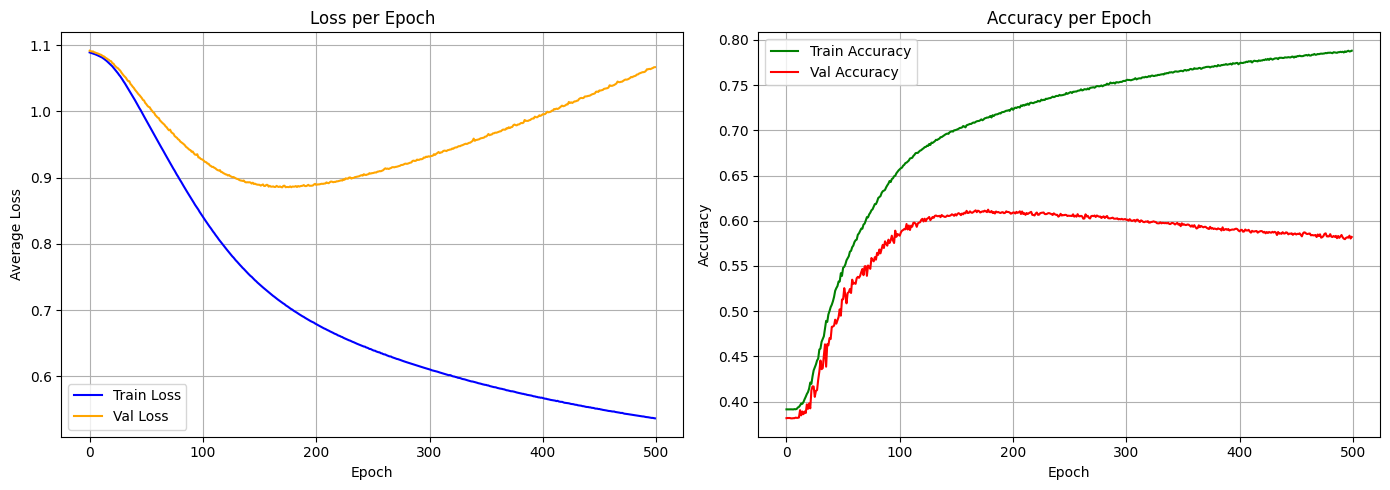

In [22]:

net_16=Net_16()
train_loss, val_loss, train_acc, val_acc = train_model(net_16, train_loader_128, val_loader_128, epochs=200)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

## Another Aproach to Improve the Classifier Component (?)

Pretty lame results, no? Let's check if the problem lies in that we take the mean over words, maybe pushing it through a larger network instead would be beneficial.

Working on cuda
Epoch 000 | Train Loss: 1.2806, Acc: 0.3727 | Val Loss: 1.0865, Acc: 0.3841
Epoch 010 | Train Loss: 0.9677, Acc: 0.5251 | Val Loss: 1.0157, Acc: 0.4860
Epoch 020 | Train Loss: 0.8365, Acc: 0.6240 | Val Loss: 0.9809, Acc: 0.5394
Epoch 030 | Train Loss: 0.6428, Acc: 0.7363 | Val Loss: 1.0536, Acc: 0.5529
Epoch 040 | Train Loss: 0.3618, Acc: 0.8707 | Val Loss: 1.4411, Acc: 0.5553
Epoch 050 | Train Loss: 0.1717, Acc: 0.9448 | Val Loss: 2.0886, Acc: 0.5448
Epoch 060 | Train Loss: 0.0916, Acc: 0.9719 | Val Loss: 2.7716, Acc: 0.5282
Epoch 070 | Train Loss: 0.0439, Acc: 0.9876 | Val Loss: 3.5110, Acc: 0.5081
Epoch 080 | Train Loss: 0.0268, Acc: 0.9932 | Val Loss: 3.9298, Acc: 0.5232
Epoch 090 | Train Loss: 0.0236, Acc: 0.9934 | Val Loss: 4.3731, Acc: 0.5276
Epoch 100 | Train Loss: 0.0203, Acc: 0.9944 | Val Loss: 4.8790, Acc: 0.5212
Epoch 110 | Train Loss: 0.1270, Acc: 0.9618 | Val Loss: 3.6090, Acc: 0.5035
Epoch 120 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 5.0613, Acc: 0.5

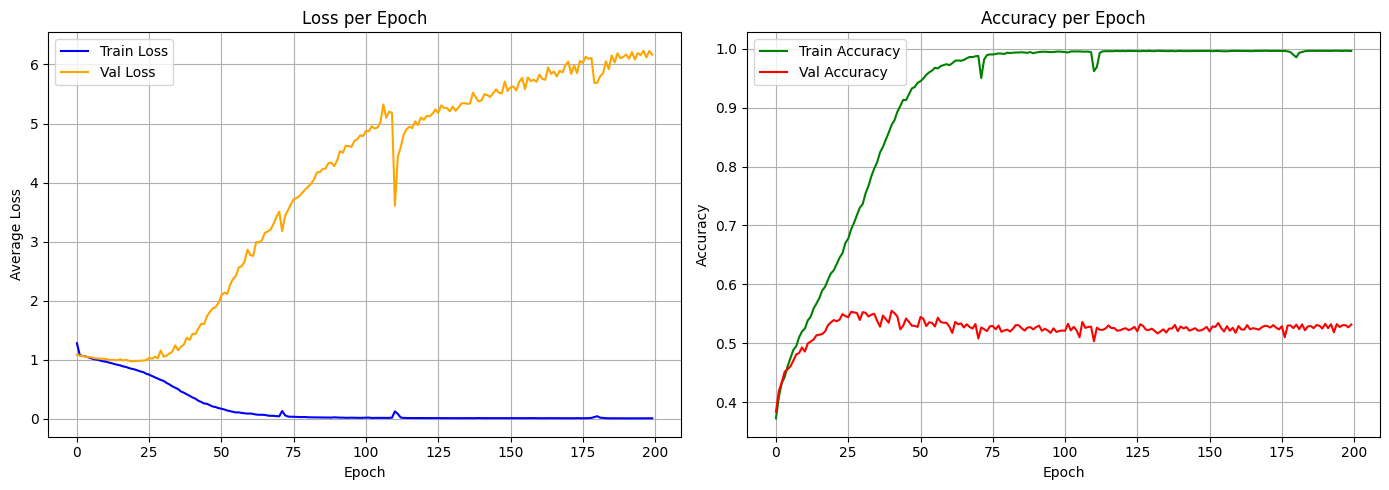

In [ ]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token
seq_len = PAD_AND_MAX_LEN

class Special_Net_16(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)

        self.classifier = torch.nn.Sequential(
                  torch.nn.Flatten(),
                  torch.nn.Linear(seq_len * feature_cnt, 4 * seq_len * feature_cnt),
                  torch.nn.ReLU(),
                  torch.nn.Linear(4 * seq_len * feature_cnt, 4 * feature_cnt),
                  torch.nn.ReLU(),
                  torch.nn.Linear(4 * feature_cnt, 3)
        )
    def forward(self, index):                        #batches, words
        feature = self.embedding(index)              #batches, words, features
        classification = self.classifier(feature)    #batches, 3
        return classification

special_net_16 = Special_Net_16()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(special_net_16, train_loader_128, val_loader_128, epochs = 100)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

## Simple Aproach

It doesn't improve. So maybe we can go simpler, then. Simple, clean and **fast**.

                                                text  \
0  My favourite food is anything I didn't have to...   
1  Now if he does off himself, everyone will thin...   
2                     WHY THE FUCK IS BAYLESS ISOING   
3                        To make her feel threatened   
4                             Dirty Southern Wankers   

                                           input_ids  
0  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 0,...  
1  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  
2  [34, 35, 36, 5, 37, 1, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [11, 39, 40, 41, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
4  [43, 44, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
Working on cuda
Epoch 000 | Train Loss: 1.6897, Acc: 0.3292 | Val Loss: 1.6331, Acc: 0.3338
Epoch 010 | Train Loss: 1.1514, Acc: 0.3270 | Val Loss: 1.1460, Acc: 0.3314
Epoch 020 | Train Loss: 1.0962, Acc: 0.3466 | Val Loss: 1.0984, Acc: 0.3509
Epoch 030 | Train Loss: 1.0910, Acc: 0.3924 | Val Loss: 1.0938, Acc: 0.3839
Epoch 040 | T

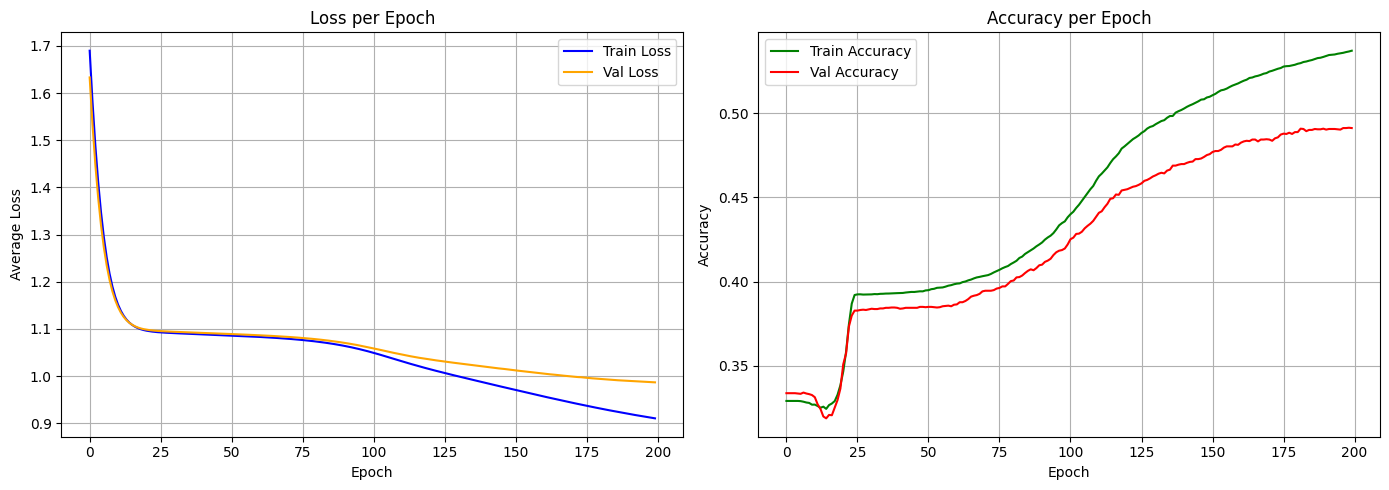

In [10]:
PAD_AND_MAX_LEN = 32
train_df, val_df, test_df, vocab = preprocess_and_tokenize(train_df_orig, val_df_orig, test_df_orig, pad_and_max_len=PAD_AND_MAX_LEN)
train_loader_32, val_loader_32, test_loader_32 = wrap_dfs_to_loaders(train_df, val_df, test_df)

# Example check
print(train_df[['text', 'input_ids']].head())

feature_cnt = 1
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_1(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 3)
    def forward(self, index):                        #batches, words
        feature = self.embedding(index)              #batches, words, features
        feature = feature.mean(-2)                   #batches, features
        classification = self.classifier(feature)    #batches, 3
        return classification

net_1 = Net_1()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_1, train_loader_32, val_loader_32, epochs = 200)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

## Sentiment polarity

Since our embeddings have only 1 feature (`feature_cnt = 1`), each word is embedded to a scalar. We can interpret this scalar as a kind of sentiment polarity, especially since our model is trained for sentiment classification.

In [11]:
import numpy as np

# Get the embedding weights as a NumPy array
embedding_weights = net_1.embedding.weight.detach().cpu().numpy().squeeze()  # shape: (vocab_len,)

# Reverse vocab dictionary to map indices back to words
id2token = {idx: token for token, idx in vocab.items()}

# Skip <PAD> and <UNK> tokens (indices 0 and 1)
valid_indices = np.array([idx for idx in range(2, len(embedding_weights)) if idx in id2token])
valid_embeddings = embedding_weights[valid_indices]

# Get top 20 most positive
top_pos_indices = valid_indices[np.argsort(-valid_embeddings)[:20]]
top_pos_words = [id2token[idx] for idx in top_pos_indices]

# Get top 20 most negative
top_neg_indices = valid_indices[np.argsort(valid_embeddings)[:20]]
top_neg_words = [id2token[idx] for idx in top_neg_indices]

# Get top 20 most neutral
top_neutral_indices = valid_indices[np.argsort(np.abs(valid_embeddings))[:20]]
top_neutral_words = [id2token[int(idx)] for idx in top_neutral_indices]

print("Top 20 most positive words:")
print(top_pos_words)

print("\nTop 20 most negative words:")
print(top_neg_words)

print("\nTop 20 most neutral words:")
print(top_neutral_words)

Top 20 most positive words:
['false', 'embarrassed', 'lol', 'scared', 'remindme', 'curious', 'crypto', 'hilarious', 'hope', 'attack', 'everytime', 'disrespect', 'glue', 'itching', 'sad', 'mutual', 'sorry', 'rationalize', 'warden', 'pigeons']

Top 20 most negative words:
['disgusting', 'thank', 'thanks', 'love', 'loved', 'happy', 'enjoy', 'agree', 'glad', 'confused', 'excited', 'loves', 'welcome', 'disappointed', 'favorite', 'wish', 'favourite', 'destruct', 'worst', 'ty']

Top 20 most neutral words:
['attract', 'drafting', 'angel', 'accountability', 'tfw', 'nice', 'caliber', 'persona', 'prime', 'baller', 'grief', 'reposting', 'houses', 'salty', 'mountains', 'fascism', 'organization', 'displayed', 'starter', 'aid']


## Classificator

It is interesting to see how the polar sentiment gets translated into three class values. It would be especialy interesting to see how it deals with the *neutral* sentiment value. Let's see:

In [17]:
# Extract weights and bias from the classifier layer
classifier_weight = net_1.classifier.weight.detach().cpu().numpy()
classifier_bias = net_1.classifier.bias.detach().cpu().numpy()

print("Classifier weights (shape: {}):".format(classifier_weight.shape))
print(classifier_weight)

print("\nClassifier bias (shape: {}):".format(classifier_bias.shape))
print(classifier_bias)

print("Recall our coding: ")
print(label2id)


Classifier weights (shape: (3, 1)):
[[-4.238717 ]
 [ 2.4826093]
 [ 1.7441598]]

Classifier bias (shape: (3,)):
[ 0.5981003 -0.6384721 -0.5655125]
Recall our coding: 
{'negative': 0, 'neutral': 1, 'positive': 2}
